# Modelo para predecir críticas de películas

## Introducción

*Film Junky Union*, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. 

## Objetivo

- Entrenar un modelo para detectar las críticas negativas y positivas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. 
- Alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [2]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords', quiet=True)

import spacy
import torch
import transformers
from transformers import BertConfig, BertModel
from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
#%config InlineBackend.figure_format = 'retina'

# plt.style.use('seaborn') # Utilizar la API de seaborn para aplicar un estilo
sns.set_style('darkgrid') # white, dark, whitegrid, darkgrid, ticks

### Cargar datos

Los datos fueron proporcionados por *Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).*

In [5]:
# cargar datos
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Descripción de campos más relevantes:
- `review`: la reseña de la película
- `pos`: el objetivo, '0' para reseña negativa y '1' para reseña positiva
- `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente.


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
# remover NAN
df_reviews.dropna(inplace=True)
df_reviews.reset_index(inplace=True, drop=True)
df_reviews.shape

(47329, 17)

In [9]:
print(df_reviews.duplicated().sum(), 'duplicated\n')

0 duplicated



In [10]:
print('Character "\\N"')
print('            end_year', round(len(df_reviews.query('end_year == r"\\N"')) / len(df_reviews),2))
print('     runtime_minutes', round(len(df_reviews.query('runtime_minutes == r"\\N"')) / len(df_reviews),2))

Character "\N"
            end_year 0.95
     runtime_minutes 0.01


Explorando el dataset tenemos los siguientes hallazgos: 
- Se encontraron 2 valores ausentes en la columna 'average_rating' y 'votes', y fueron eliminados.
- No existen registros duplicados. 
- Hemos encontrado el caracter "\N" en 2 columnas. 
    - En las columna 'end_year' el 95% tiene este caracter, debido a que es un porcentaje alto (cercano a 100%), consideramos eliminar la columna ya que no aporta información válida. 
    - En la columna 'runtime_minutes' encontramos el 1% de este caracter, siendo un porcentaje bastante bajo, vamos a eliminar los registros que lo contienen.

In [11]:
# Eliminamos columna 'end_year'
df_reviews = df_reviews.drop(['end_year'], axis=1)

# Eliminamos registros con valores "\\N" en la columna 'runtime_minutes' 
df_reviews = df_reviews[df_reviews['runtime_minutes'] != '\\N']
df_reviews.shape

(46843, 16)

Nuestro dataset después del preprocesado queda con  46.843 registros y 16 columnas.

# Análisis exploratorio de datos

### Número de películas por año
Veamos el número de películas y reseñas a lo largo de los años.

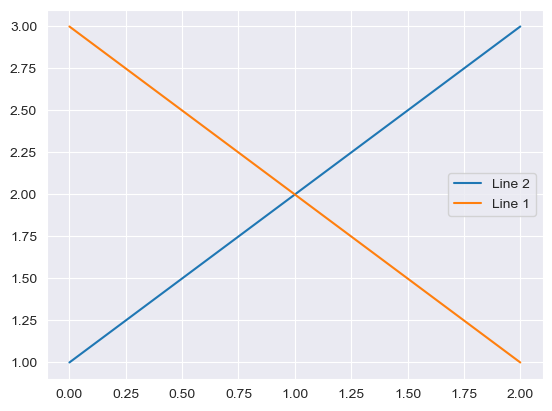

In [35]:
fig, ax = plt.subplots()
line_up, = ax.plot([1, 2, 3], label='Line 2')
line_down, = ax.plot([3, 2, 1], label='Line 1')
ax.legend(handles=[line_up, line_down])

In [58]:
labels

['0', '1', 'reviews per movie (avg over 5 years)']

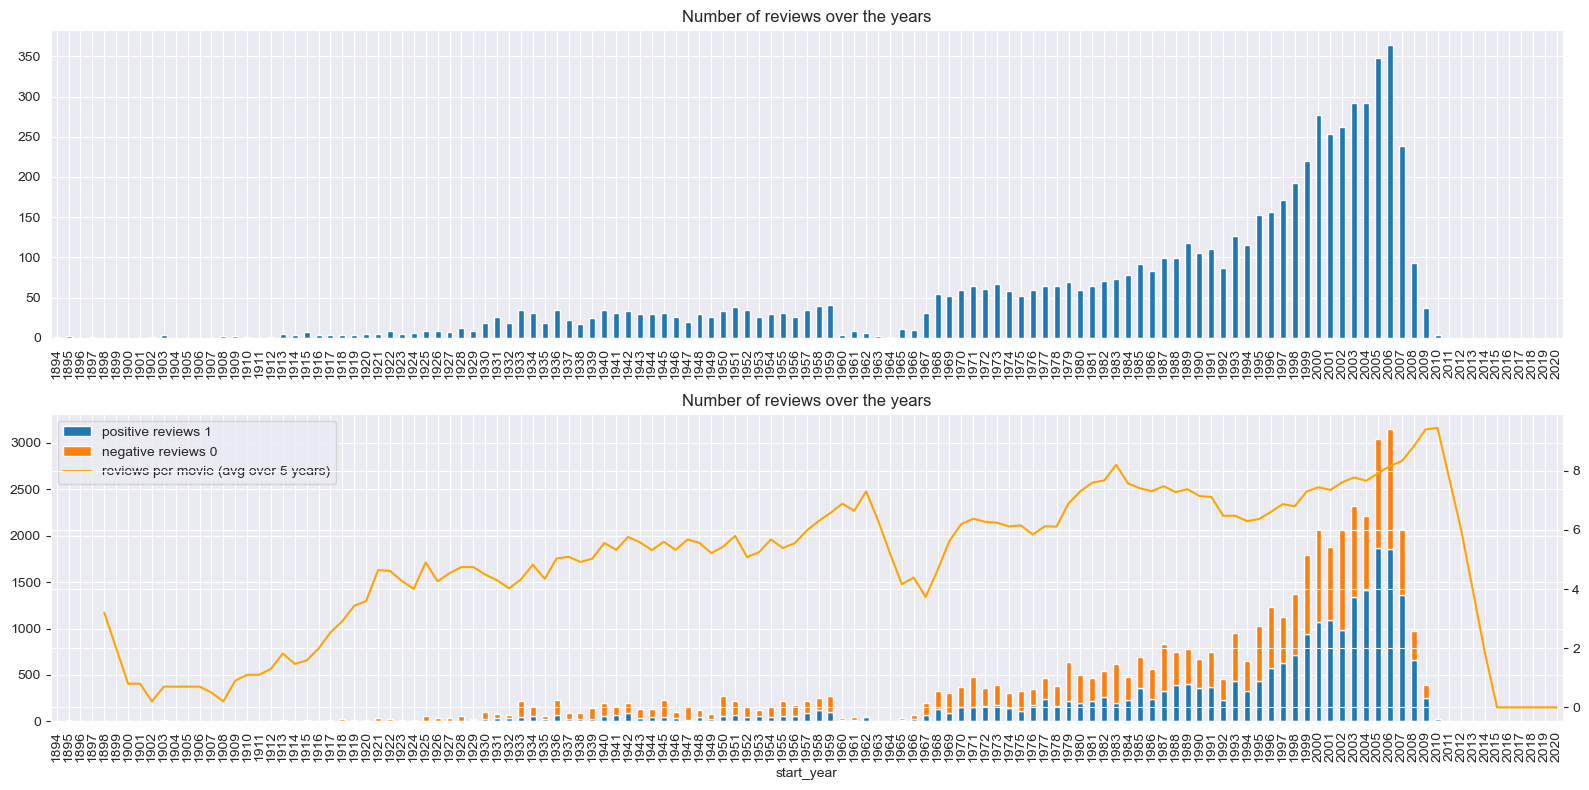

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Graph # 1
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of reviews over the years')

# Graph # 2
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)
lines1, labels1 = ax.get_legend_handles_labels()
labels1=['positive reviews 1', 'negative reviews 0']

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines2, labels2 = axt.get_legend_handles_labels()

lines = lines1+lines2
labels = labels1+labels2

ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of reviews over the years')

fig.tight_layout()

Observamos que con el paso del tiempo las personas realizan cada vez más y más críticas a las películas. En el 2006 y 2007 fueron años en que se aprecian mayor incremento en escritura de reviews, en los años 2000 surgen compañias de streaming, seguramente esto hace más popular realizar críticas por parte de los usuarios de películas.

### Reseñas por películas
Veamos la distribución del número de reseñas por película con el conteo exacto y KDE  "kernel density estimate" (solo para saber cómo puede diferir del conteo exacto)

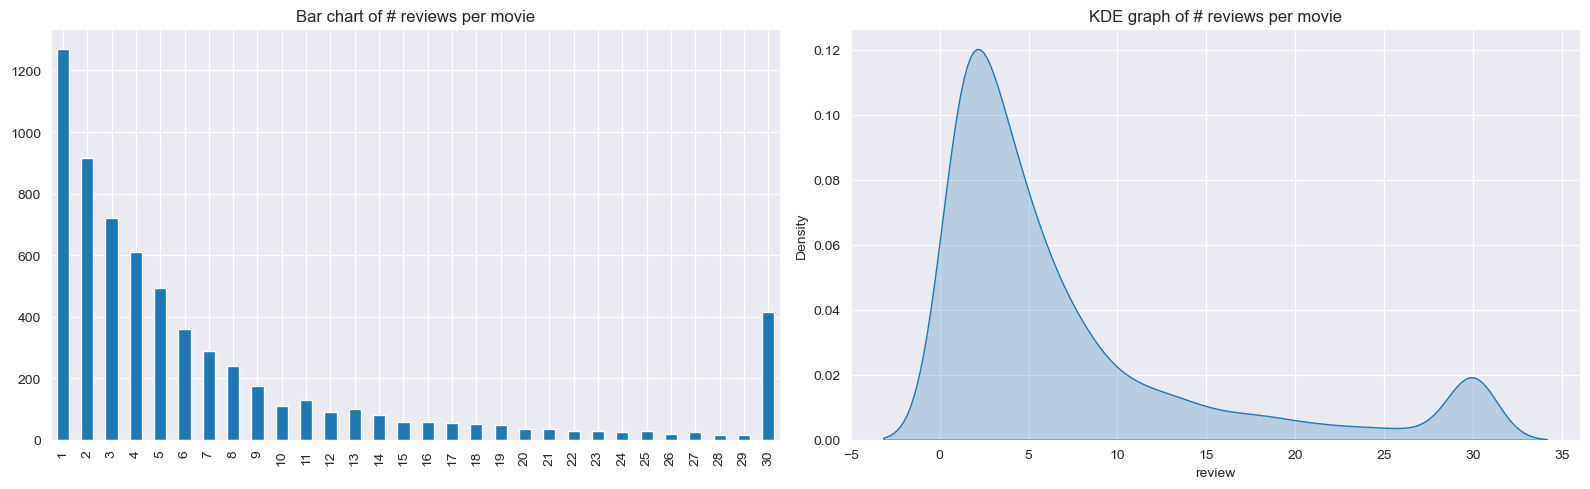

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of # reviews per movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax, fill=True)
ax.set_title('KDE graph of # reviews per movie')

fig.tight_layout()

Existe más de 1200 películas con un solo review. Menos de 200 pelíuclas obtuvieron de 9 a más reviews.

### Críticas positivas y negativas de las películas

<Axes: >

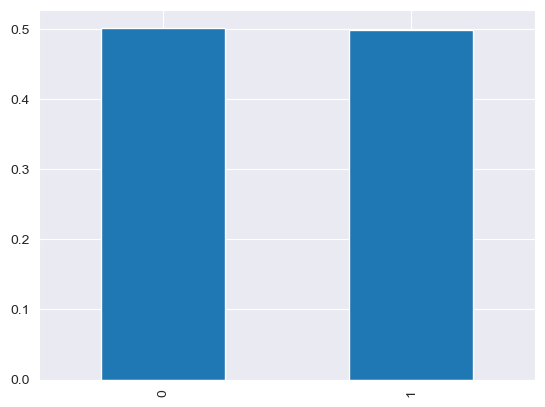

In [13]:
df_reviews['pos'].value_counts(normalize=True).plot(kind='bar')

Las críticas negativas "0" y positivas "1" están balanceadas. Esto es bueno para el entrenamiento de modelos posteriores.

### Distribución de puntuaciones de películas

Revisemos como están la distribución de puntuaciones de películas, en el dataset de prueba y de test.

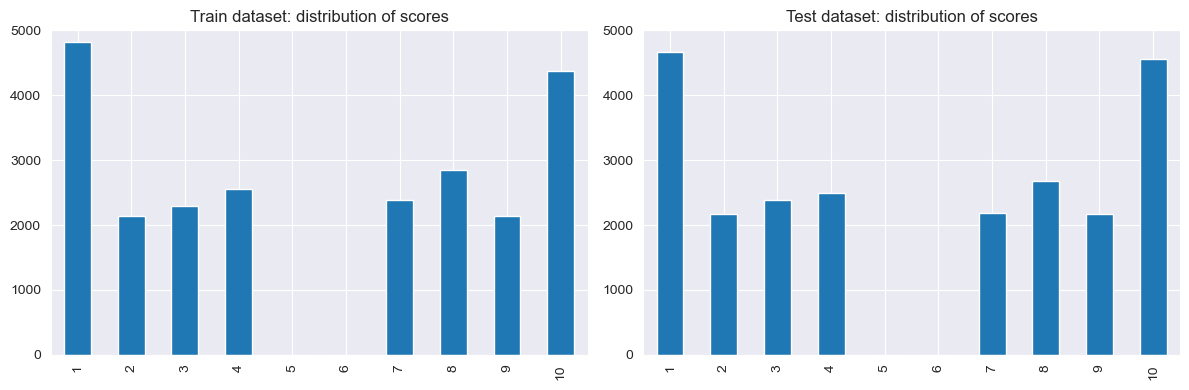

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train dataset: distribution of scores')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test dataset: distribution of scores')

fig.tight_layout()

Observamos las distribuciones de puntuaciones de películas similarmente representadas, tanto en el dataset de entrenamiento como en el de test.

### Reseñas negativas y positivas de películas por año

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [67]:
dft

pos,0,1
tconst,,
tt0000030,NaN,1.0
tt0000208,NaN,4.0
tt0000399,1.0,NaN
tt0000430,NaN,1.0
tt0000653,1.0,NaN
...,...,...
tt0995582,NaN,5.0
tt0995840,13.0,NaN
tt0997057,3.0,NaN


In [95]:
df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()

pos,0,1
start_year,,
1895,NaN,11.0
1903,1.0,NaN
1908,NaN,1.0
1909,2.0,5.0
1910,1.0,NaN
...,...,...
2006,993.0,581.0
2007,713.0,503.0
2008,372.0,151.0


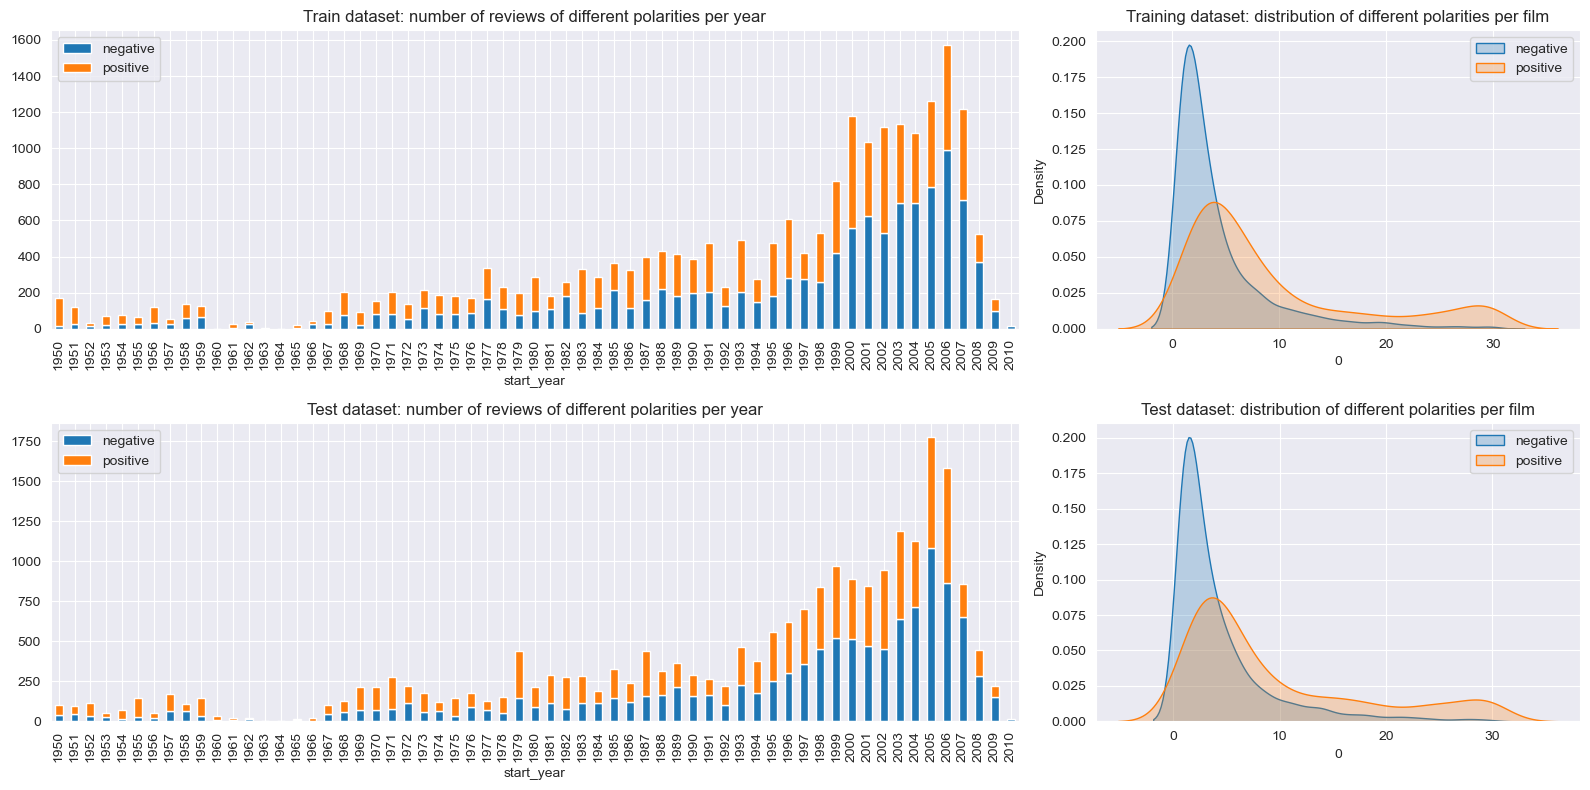

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.loc[1950:2010].plot(kind='bar', stacked=True, ax=ax)
ax.legend(['negative','positive'])
ax.set_title('Train dataset: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], label='negative', ax=ax, fill=True) # kernel='epa', 
sns.kdeplot(dft[1], label='positive', ax=ax, fill=True)
ax.legend()
ax.set_title('Training dataset: distribution of different polarities per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.loc[1950:2010].plot(kind='bar', stacked=True, ax=ax)
ax.legend(['negative','positive'])
ax.set_title('Test dataset: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], label='negative', ax=ax, fill=True)
sns.kdeplot(dft[1], label='positive', ax=ax, fill=True)
ax.legend()
ax.set_title('Test dataset: distribution of different polarities per film')

fig.tight_layout()

Existen más críticas negativas que positivas en los años 2005 y 2006 (para ambos conjutos de datos de entrenamiento y de test). 

Entre 0 a 10 reviews tienen la mayor parte de criticas tanto positivas como negativas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
summary_models = pd.DataFrame(columns=['model', 'npl', 'F1 train', 'F1 test']).set_index('model')

In [17]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    '''
    parameters:    
    model: model previously trained and with hyperparameter tuning
    train_features: features dataset train
    train_target_: target dataset train
    test_features: objetivo de entrenamiento
    test_target: objetivo de prueba
    
    return the values for accuracy, average precision, F1, ROC-AUC. Also returns ROC-AUC, F1 and PRC (precision-recall curve) plots
    '''

    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC (Precision Recall Curve)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)

        # APS (Precision Media Score)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot
        
        # F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Normalización

Como parte del procesamiento de los datos vamos a realizar una normalización construiremos una nueva columna con el review normalizado, es decir, valos a limpiar nuestros textos en el review, dejando solo texto en minúsculas, sin dígitos, signos de puntuación o espacios adicionales. 

Creamos una función llamada `clear_text` que realizara la limpieza necesaria en esta normalización, y también limpiará palabras vacías (topwords):

In [18]:
def clear_text(text):
    pattern = r"[^a-zA-Zñ']"
    text = re.sub(pattern, " ", text).lower()
    stop_words = set(stopwords.words("english"))
    list_words = text.split()
    filtered_words = [word for word in list_words if word not in stop_words]
    text = " ".join(filtered_words) 

    return text

In [19]:
# create normalized review 
df_reviews['review_norm'] = df_reviews.review.apply(clear_text)
print(df_reviews.review[100],'\n',df_reviews.review_norm[100])

Years ago, Sara, a young girl witnessed her parents being murdered, now as an adult she suffers from various mental ailments (did I mention she has an imaginary friend?) This film lulls the viewer, not into a sense of tension, mind you, but rather a sense of sleepiness. Deathly boring, I found it hard to sit through as I could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery'. Is Sara going crazy? or is it the paranormal? A better question would be, Who cares? And the answer to that, no one. No one at all. Skip this film, save yourself some time better suited to do other more worthwhile tasks. My Grade: D- 
 years ago sara young girl witnessed parents murdered adult suffers various mental ailments mention imaginary friend film lulls viewer sense tension mind rather sense sleepiness deathly boring found hard sit could feel eyelids growing heavier heavier endless minute mindless prattle supposed 'mystery' sara going crazy para

# Entrenar modelos

## Segmentación: entrenamiento y prueba

Primero realizaremos la segmentación de los datos para el entrenamiento y pruebas, indicado en la columna 'ds_part', guardamos en `train` y `test` respectivamente. 

Además estableceremos las variables objetivo como `y_train`, y `y_test`, que usaremos para todos nuestros modelos.

Como en este proyecto iremos poniendo en práctica distintas técnicas de procesamiento de texto, los reviews que son nuestras features, serán procesadas y variadas, por lo que se irá indicando las transformaciones previo al entrenamiento de los modelos.

In [20]:
# Segmentamos train y test
train = df_reviews.query('ds_part == "train"').copy()
test = df_reviews.query('ds_part == "test"').copy()
print('train', train.shape)
print('test', test.shape)

# Segmentamos target
y_train = train['pos']
y_test = test['pos']

train (23552, 17)
test (23291, 17)


Realizaremos varios modelos usando técnicas para el procesamiento de texto como son:
- NLTK y TF-IDF
- spaCy y TF-IDF
- Bert

Además entrenaremos varios modelos predictivos de clasificación: 
- Logistic Regression
- Random Forest Classifier
- LGBM Classifier

Además tendremos un modelo constante, para poder hacer un test de cordura.

## Modelo 0: Constante

Realizaremos un modelo constante, el cual va a predecir la clase más frecuente. Este modelo será la base para posteriormente realizar una prueba de cordura con nuestro mejor modelo.

          train  test
Accuracy   0.50  0.50
F1         0.67  0.66
APS        0.50  0.50
ROC AUC    0.50  0.50


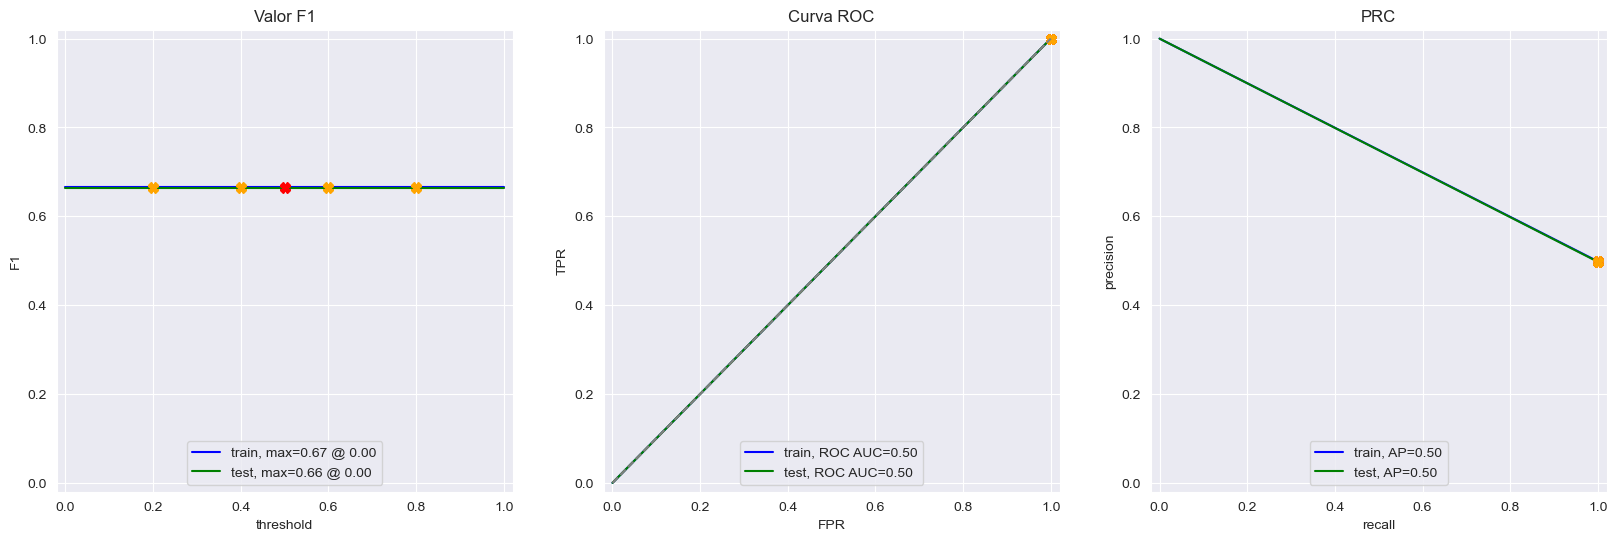

In [21]:
# Features 
X_train = train['review_norm'].copy()
X_test = test['review_norm'].copy()

# Create a constant model it always to predict positive class
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(X_train, y_train)
result = evaluate_model(model_dummy, X_train, y_train, X_test, y_test)

In [22]:
summary_models.loc['model 0 - dummy'] = {'npl':'only normalizer', 'F1 train': result.iloc[1][0], 'F1 test': result.iloc[1][1]}

Ahora tenemos un modelo base.

Observamos que nuestro modelo constante tiene un score F1 de 0.66 y Accuracy/APS/ROC curve de 0.50. Nuestro mejor modelon de los que entrenaremos a continuación, deberá estar mejor ajustado que este modelo dummy para pasar la prueba de cordura.

## Modelos 1-3: Procesamiento de texto con NLTK y TF-IDF 

Antes de entrenar nuestros modelos, vamos a procesar los "reviews" aplicando la lematización con NLTK y vectorizar por medio de TF-IDF (Frecuencia de Término — Trecuencia Inversa de Documento) para transformar nuestro texto en números, para que los reviews puedan ser leidos por los modelos de machine learning. 

2 pasos:

1. `Lematrizar`: La lematización es el proceso de reducir una palabra a su forma base o raíz, así reducimos la dimensionalidad de los datos. La lematización debe realizarse desde los textos ya normalizados (limpios), lo cual lo hicimos previamente con la función 'clean_text'.
2. `TF-IDF`: Convierte nuestros textos lematizados en una matriz de números. TF-IDF es una medida estadística que se utiliza para evaluar la importancia de una palabra en un documento en relación con una colección de documentos o corpus.

In [23]:
def lemmatizer_nltk(text):
    '''
    text: original text
    return lemmatized text with NLTK
    '''
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(text) 
    pos = wordnet.VERB  # The POS tag must be one of the constants defined in the wordnet module
    lemmas = [lemmatizer.lemmatize(token, pos) for token in tokens]
    return " ".join(lemmas)

In [24]:
%%time
# lemmatization
X_train_lemm = X_train.apply(lemmatizer_nltk)
X_test_lemm  = X_test.apply(lemmatizer_nltk)

# TF-IDF
vectorizer_123 = TfidfVectorizer()
X_train_123 = vectorizer_123.fit_transform(X_train_lemm)
X_test_123  = vectorizer_123.transform(X_test_lemm)

print(X_train.iloc[100], '\n', X_train_lemm.iloc[100],'\n')
print('TF-IDF Matrix X train', X_train_123.shape)

print(X_test.iloc[100], '\n', X_test_lemm.iloc[100])
print('TF-IDF Matrix X test:', X_test_123.shape)

plot terrible film convoluted i've put spoiler warning i'm unsure i'm giving anything away audience first sees man jack ripper garb murder old man alley hundred years ago we're modern day young australian couple looking house we're given unbelievably long tour house husband sees figure old mirror year old woman lived also large iron panels covering wall den old fashioned straight razor falls they're renovating husband keeps guess becomes possessed razor starts weird dreams oh yeah couple unable baby husband firing blanks mold seems climbing wall couple removes iron panels mold shape person late story plot large cache money husband murders body guard co worker steals money wife suddenly pregnant hell going knows nothing explained year old woman child serial killer baby sister iron panels put wall would keep serial killer contained cellar locked family starved death concealed mr hobbs desperate get iron panels he's never seen serial killer killing people see one old man murdered pattern 

El modelo 1 2 y 3 lo vamos a entrenar con las features de entreanmiento `X_train_123` y prueba `X_test_123`.

Vamos a dejar una función `grid_search_cv` para realizar la búsqueda de mejores hiperámetros en cada modelo que vamos a entrenar; esto nos sirve para realizar un ajuste de hiperparámetros que nos ayudará a mejorar nuestros modelos.

In [25]:
# Function grid_search for search best parameters

def grid_search_cv(estimator, params, X, y):
    '''
    parameters:
    "estimator": algorithm to train
    "params": hyperparameters to test
    "x": features train
    "y": target train
    return: the best parameters tested
    '''
  
    grid_search= GridSearchCV(estimator=estimator, param_grid=params, scoring='f1', cv=5, error_score='raise')
    grid_search.fit(X, y)
    best_params  = grid_search.best_params_

    print(f'Best hiperparameters: {best_params}')
    return best_params

### 1-Entrenamiento con "LogisticRegression"

In [26]:
# Tuning hyperparameters:

# params_lr = {'penalty': ['l1','l2'], 
#              'C': [0.1, 1.0],
#              'solver': ['liblinear','saga']
#              }

# params = grid_search_cv(LogisticRegression(random_state=12345), params_lr, X_train_123, y_train)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 547 ms
Wall time: 1.13 s


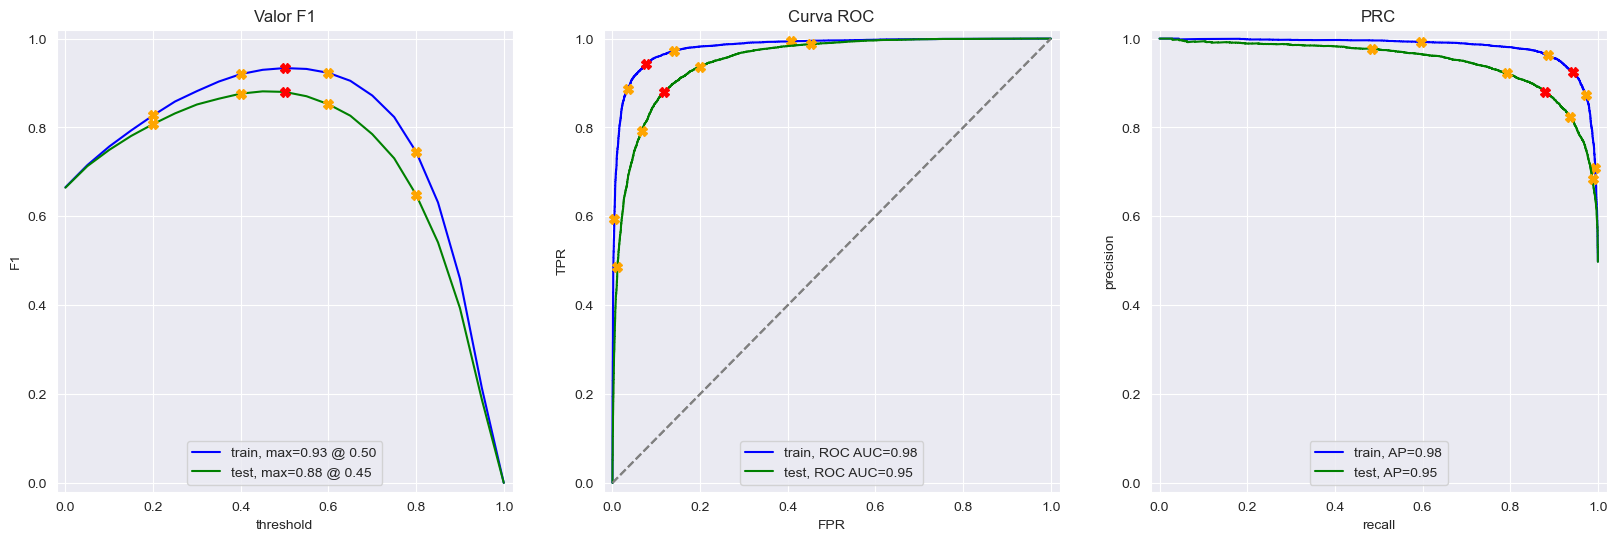

In [27]:
%%time
# Training LogisticRegression

params = {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
model_lr = LogisticRegression(random_state= 12345, penalty=params['penalty'], C=params['C'], solver=params['solver'])
model_lr.fit(X_train_123, y_train)
result_1 = evaluate_model(model_lr, X_train_123, y_train, X_test_123, y_test )

In [28]:
summary_models.loc['model 1 - LogisticRegression'] = {'npl':'nltk and tfidf', 'F1 train': result_1.iloc[1][0], 'F1 test': result_1.iloc[1][1]}

Los resultados de nuestro entrenamiento con LogisticRegression son evidentes, el modelo ha obtenido buenos score. Entre estos nuestro F1 tiene 0.93 en el entrenamiento, y 0.88 en la prueba. La curva-roc nos manifiesta el excelente ajuste. Aunque observamos un poco de overfitting en este modelo.

Con este modelo hemos superado la prueba de cordura con nuestro modelo dummy.

### 2-Entrenamiento con "RandomForestClassifier"

In [29]:
# Tuning hyperparameters:

# params_rf = {'n_estimators': [5, 100, 150],
#              'criterion': ["gini", "entropy", "log_loss"],
#              'max_depth': [4,6,8,10],
#              }

# params = grid_search_cv(RandomForestClassifier(random_state=12345), params_rf, X_train_123, y_train)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 2.28 s
Wall time: 5.46 s


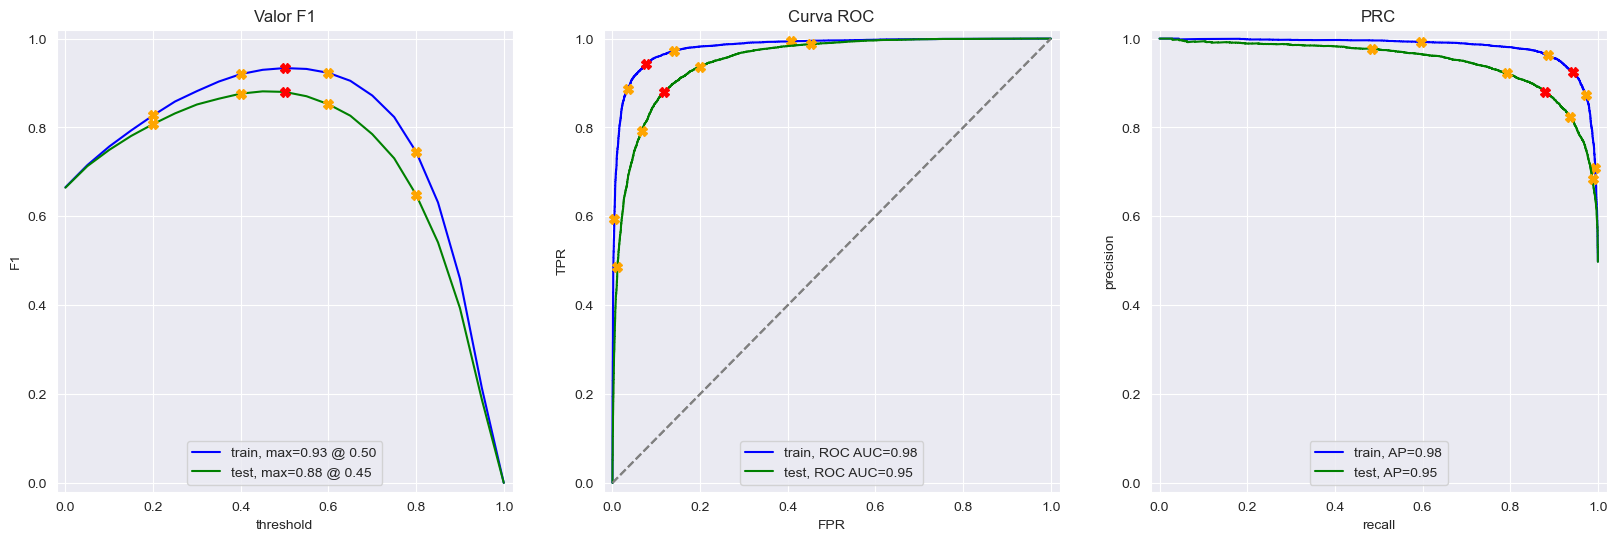

In [30]:
%%time
# Training RandomForestClassifier
params = {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
model_rf = RandomForestClassifier(n_estimators=params['n_estimators'], criterion=params['criterion'], max_depth=params['max_depth'] )
model_rf.fit(X_train_123, y_train)
result_2 = evaluate_model(model_lr, X_train_123, y_train, X_test_123, y_test )

In [31]:
summary_models.loc['model 2 - RandomForestClassifier'] = {'npl':'nltk and tfidf', 'F1 train': result_2.iloc[1][0], 'F1 test': result_2.iloc[1][1]}

Observamos nuestros score en el modelo entrenado RandomForestClassifier. El F1 es de 0.93 en el entrenamiento, y 0.88 en la prueba. La curva-roc también nos manifiesta un gran ajuste. También nos muestra un poco de overfitting.

### 3-Entrenamiento con "LGBMClassifier"

In [32]:
# Tuning hyperparameters:

# params_lgbm = {
#     'objective' : ['binary'], 
#     'n_estimators' : [50, 100, 150],
#     'max_depth': [2,4,8]
# }

# params = grid_search_cv(LGBMClassifier(random_state=12345), params_lgbm, X_train_123, y_train)

          train  test
Accuracy   0.92  0.85
F1         0.93  0.85
APS        0.98  0.93
ROC AUC    0.98  0.93
CPU times: total: 1min 44s
Wall time: 13.3 s


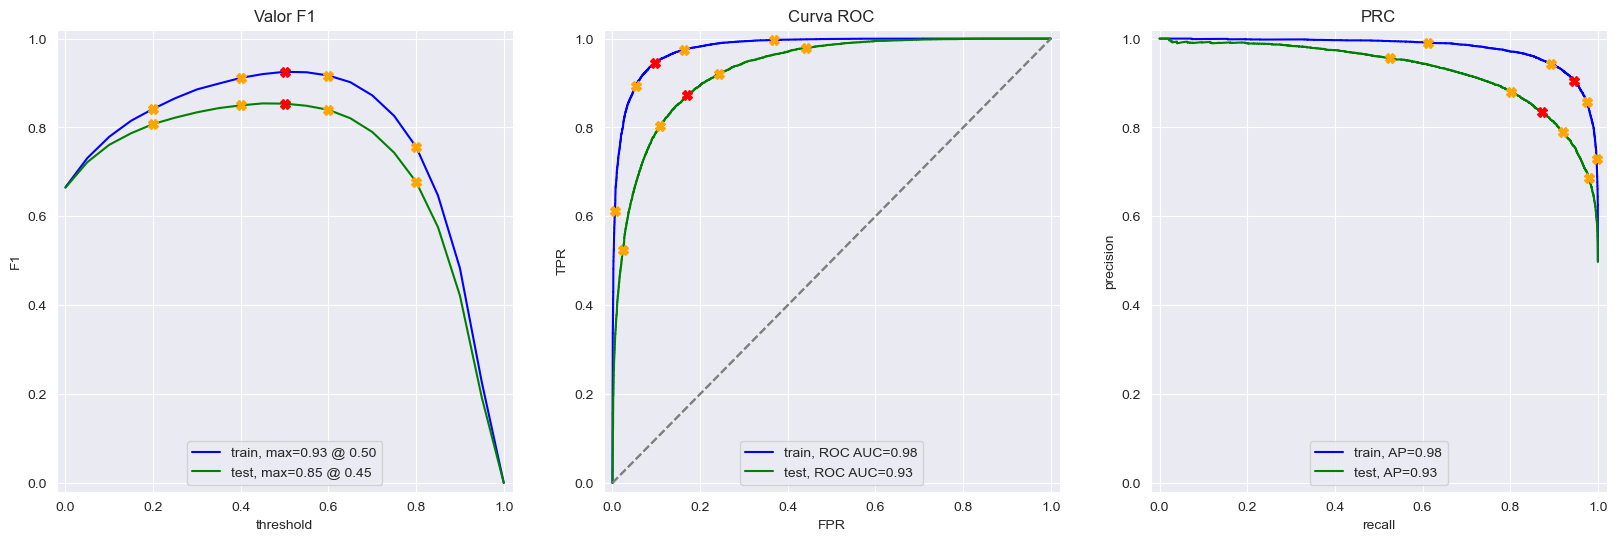

In [33]:
%%time
# Training LGBMClassifier
params = {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}
model_lgbm = LGBMClassifier(random_state= 12345, max_depth= params['max_depth'], n_estimators=params['n_estimators'], objective=params['objective'])
model_lgbm.fit(X_train_123, y_train)
result_3 = evaluate_model(model_lgbm, X_train_123, y_train, X_test_123, y_test )

In [34]:
summary_models.loc['model 3 - LGBMClassifier'] = {'npl':'nltk and tfidf', 'F1 train': result_3.iloc[1][0], 'F1 test': result_3.iloc[1][1]}

En este tercer entrenamiento, nuestro modelo con LGBM tiene un score F1 con los datos de entranmiento 0.93 y 0.85 con los de test.

## Modelo 4-6: Procesamiento de texto con spaCy y TF-IDF

Vamos a realizar procesamiento de texto a nuestras features para nuestros próximos 3 modelos; usaremos spaCy y TF-IDF. Veamos qué resultados tendremos cambiando el procesamiento del texto.

In [35]:
# # enable the use of the GPU/CPU
# # spacy.require_cpu()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
def lemmatizer_spacy(text):
    '''
    text: original text
    return lemmatized text with spaCy
    '''

    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [37]:
%%time
# lemmatization

X_train_lemm_2 = X_train.apply(lemmatizer_spacy)
X_test_lemm_2  = X_test.apply(lemmatizer_spacy)

# TF-IDF
vectorizer_456 = TfidfVectorizer()
X_train_456 = vectorizer_456.fit_transform(X_train_lemm_2)
X_test_456  = vectorizer_456.transform(X_test_lemm_2)

print(X_train.iloc[100], '\n', X_train_lemm_2.iloc[100],'\n')
print('TF-IDF Matrix X train', X_train_456.shape)

print(X_test.iloc[100], '\n', X_test_lemm_2.iloc[100])
print('TF-IDF Matrix X test:', X_test_456.shape)

plot terrible film convoluted i've put spoiler warning i'm unsure i'm giving anything away audience first sees man jack ripper garb murder old man alley hundred years ago we're modern day young australian couple looking house we're given unbelievably long tour house husband sees figure old mirror year old woman lived also large iron panels covering wall den old fashioned straight razor falls they're renovating husband keeps guess becomes possessed razor starts weird dreams oh yeah couple unable baby husband firing blanks mold seems climbing wall couple removes iron panels mold shape person late story plot large cache money husband murders body guard co worker steals money wife suddenly pregnant hell going knows nothing explained year old woman child serial killer baby sister iron panels put wall would keep serial killer contained cellar locked family starved death concealed mr hobbs desperate get iron panels he's never seen serial killer killing people see one old man murdered pattern 

Para los modelos 4, 5 y 6 usaremos nuestras nuevas características procesadas: `X_train_456`, y `X_test_456`

### 4-Entrenamiento con "LogisticRegression" 

In [38]:
# Tuning hyperparameters:

# params_lr = {'penalty': ['l1','l2'], 
#              'C': [0.1, 1.0],
#              'solver': ['liblinear','saga']
#              }

# params = grid_search_cv(LogisticRegression(random_state=12345), params_lr, X_train_456, y_train)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 1.7 s
Wall time: 791 ms


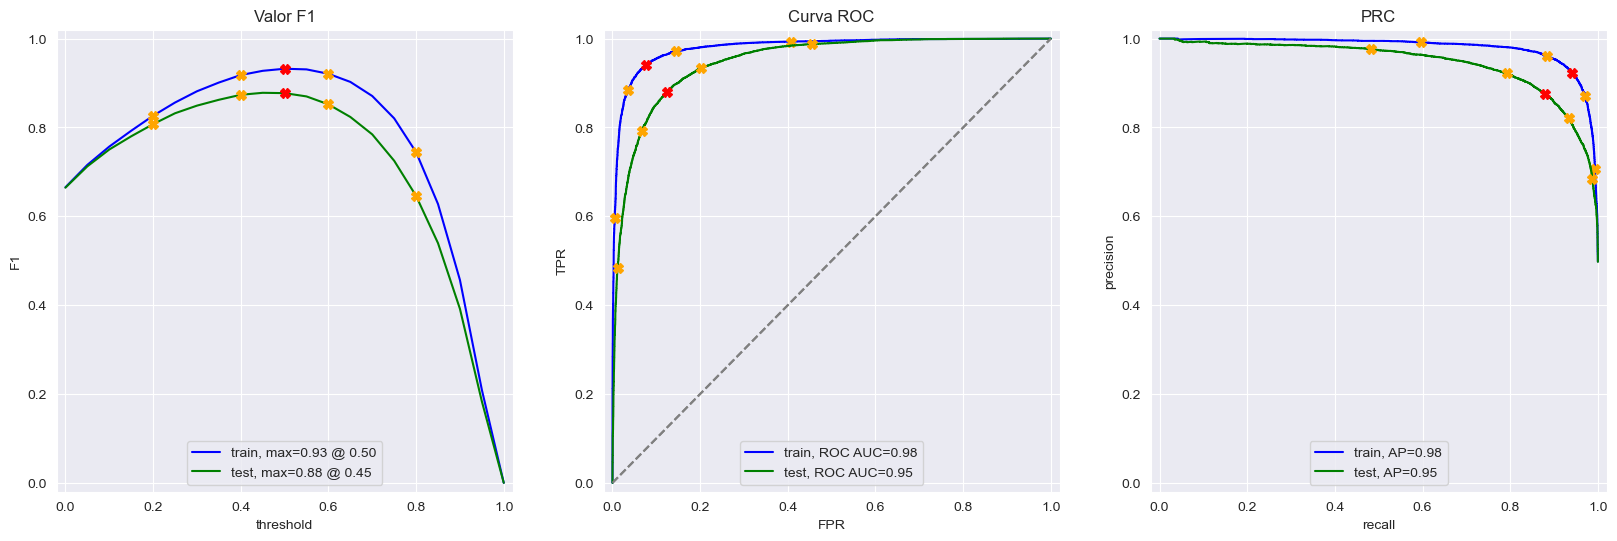

In [39]:
%%time

# Training LogisticRegression
params = {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
model_lr_2 = LogisticRegression(random_state= 12345, penalty=params['penalty'], C=params['C'], solver=params['solver'])
model_lr_2.fit(X_train_456, y_train)
result_4 = evaluate_model(model_lr_2, X_train_456, y_train, X_test_456, y_test)

In [40]:
summary_models.loc['model 4 - LogisticRegression'] = {'npl':'spaCy and tfidf', 'F1 train': result_4.iloc[1][0], 'F1 test': result_4.iloc[1][1]}

En este cuarto entrenamiento con LogisticRegression, nuestro modelo tiene un score F1 con los datos de entrenamiento 0.93 y 0.88 con los de test. No existe mayor diferencia entre los resultados del modelo 1 con el mismo algoritmo pero con diferente procesamiento de textos.

### 5-Entrenamiento con "RandomForestClassifier"

In [41]:
# Tuning hyperparameters:

# params_rf = {'n_estimators': [5, 100, 150],
#              'criterion': ["gini", "entropy", "log_loss"],
#              'max_depth': [4,6,8,10],
#              }

# params = grid_search_cv(RandomForestClassifier(random_state=12345), params_rf, X_train_456, y_train)

          train  test
Accuracy   0.88  0.83
F1         0.88  0.83
APS        0.95  0.90
ROC AUC    0.95  0.91
CPU times: total: 3.02 s
Wall time: 9.77 s


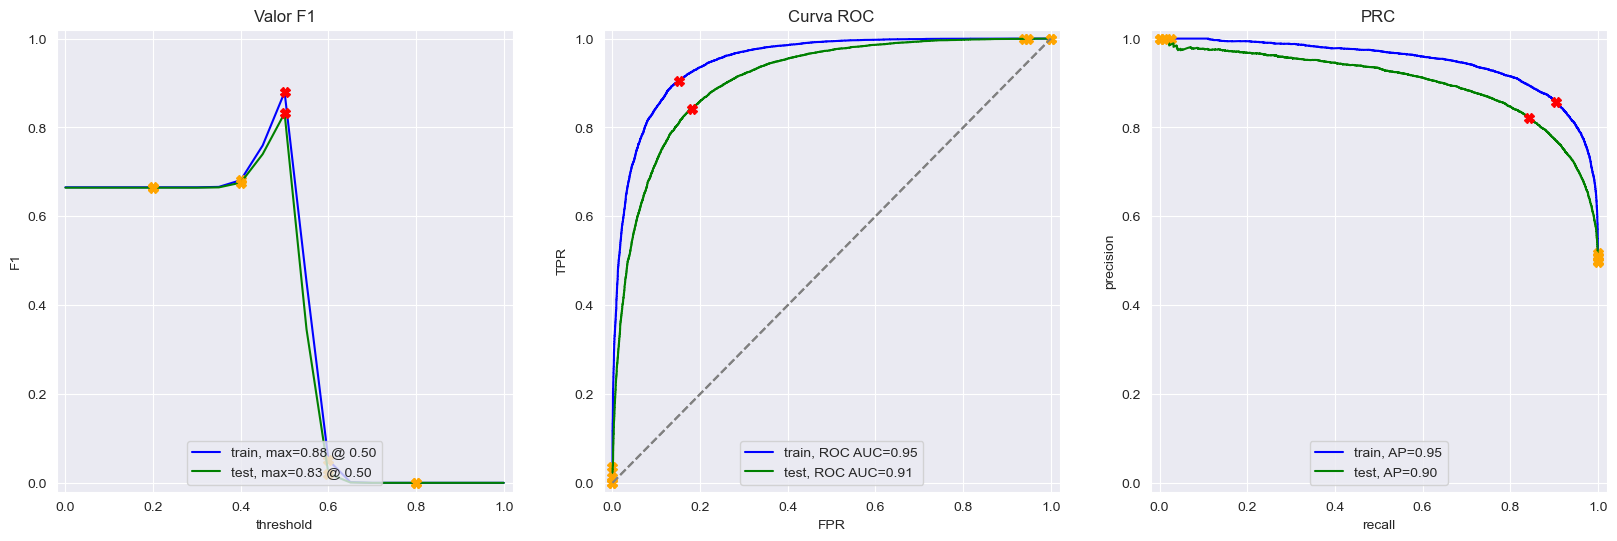

In [42]:
%%time
# Training RandomForestClassifier
params = {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
model_rf_2 = RandomForestClassifier(n_estimators=params['n_estimators'], criterion=params['criterion'], max_depth=params['max_depth'] )
model_rf_2.fit(X_train_456, y_train)
result_5 = evaluate_model(model_rf_2, X_train_456, y_train, X_test_456, y_test )

In [43]:
summary_models.loc['model 5 - RandomForestClassifier'] = {'npl':'spaCy and tfidf', 'F1 train': result_5.iloc[1][0], 'F1 test': result_5.iloc[1][1]}

Este entrenamiento con RandomForestClassifier, nuestro modelo con LGBM tiene un score F1 con los datos de entranmiento 0.88 y 0.83 con los de test. Este modelo ciertamente empeoró con respecto al otro preprocesamiento.

### 6-Entrenamiento con "LGBMClassifier" 

In [44]:
# Tuning hyperparameters:

# params_lgbm = {
#     'objective' : ['binary'], 
#     'n_estimators' : [50, 100, 150],
#     'max_depth': [2,4,8]
# }

# params = grid_search_cv(LGBMClassifier(random_state=12345), params_lgbm, X_train_456, y_train)

          train  test
Accuracy   0.94  0.86
F1         0.94  0.86
APS        0.99  0.94
ROC AUC    0.99  0.94
CPU times: total: 2min 36s
Wall time: 16.3 s


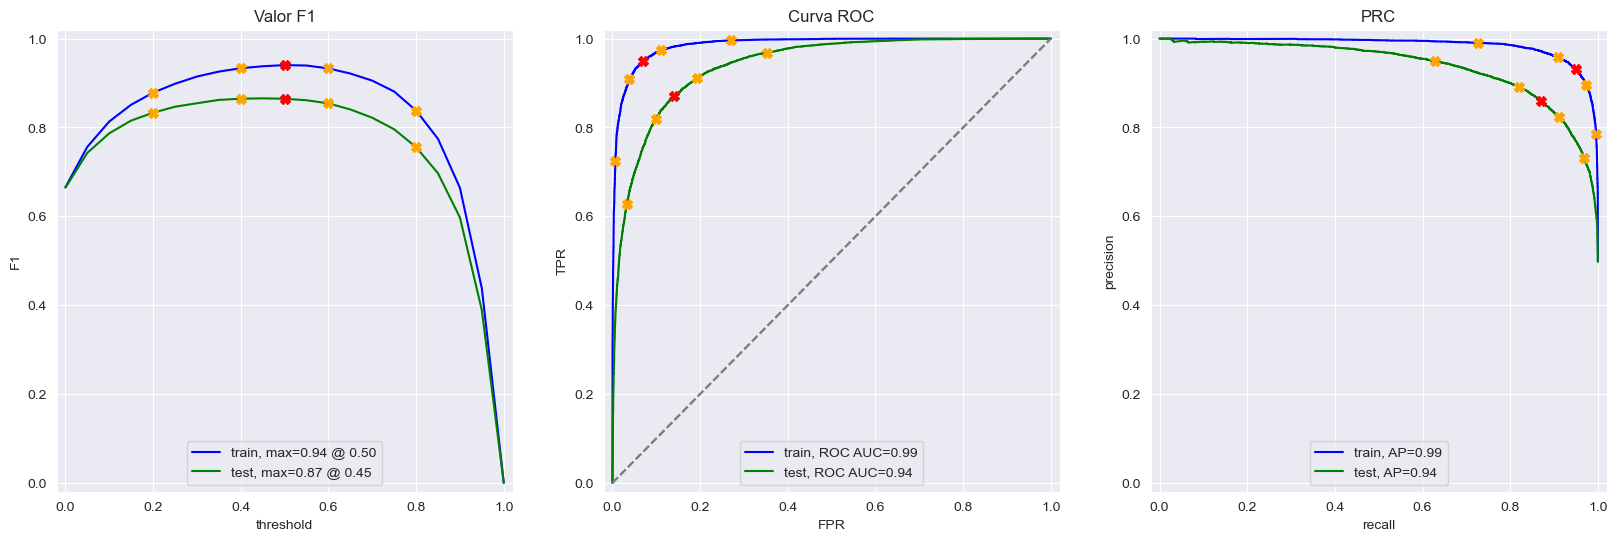

In [45]:
%%time
# Training LGBMClassifier
params = {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}
model_lgbm_2 = LGBMClassifier(random_state= 12345, n_estimators=params['n_estimators'], objective=params['objective'])
model_lgbm_2.fit(X_train_456, y_train)
result_6 = evaluate_model(model_lgbm_2, X_train_456, y_train, X_test_456, y_test )

In [46]:
summary_models.loc['model 6 - LGBMClassifier'] = {'npl':'spaCy and tfidf', 'F1 train': result_6.iloc[1][0], 'F1 test': result_6.iloc[1][1]}

EL modelo entrenado con LGBM ha obtenido un F1 tiene 0.94 en el entrenamiento, y 0.86 en la prueba. Tenemos mejores resultados que con el procesamiento anterior.

##  Modelo 7-9: Procesamiento de texto con BERT

Realizaremos un procesamiento de textos usando BERT. No se necesita lematizar previamente los reviews.

In [47]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    """
    parameters:
     texts to process
     max_length total tokens
     batch_size for batches

    return features process
    """
    batch_size = 25 # reduce memory requirements

    #  ids token list of size "max_length" with padding of 0, and attention mask list
    ids_list = [] 
    attention_mask_list = [] 

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length) 
        padded = np.array(ids + [0] * (max_length - len(ids))) # create an array where the first values are those of 'ids' the rest 0.
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    # Device to use to execute operations with PyTorch,
    # depending on the value of force_device, and whether a GPU is available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Uso del dispositivo {device}.')
    model.to(device)


    # get inserted in batches
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        # Create ids token batch. Union of ids vectors to a tensor
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        # Create attention_mask batch. Union of attention mask vectors to a tensor
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * ( i + 1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

**¡Atención!** La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas. Por lo que usaremos 500 review en cada ambiente.

In [49]:
# Target 500 train, 500 test
y_train_500 = train['pos'].iloc[0:500]
y_test_500  = test['pos'].iloc[0:500]

# Features 500 train, 500 test
X_train_500 = train['review_norm'].iloc[0:500]
X_test_500  = test['review_norm'].iloc[0:500]

In [50]:
%%time
# PNL BERT
X_train_789 = BERT_text_to_embeddings(X_train_500, force_device='cuda')
X_test_789 =  BERT_text_to_embeddings(X_test_500, force_device='cuda')

Uso del dispositivo cpu.


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\angel\AppData\Local\Temp\ipykernel_40124\2034903521.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


Uso del dispositivo cpu.


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: total: 41min 41s
Wall time: 13min 28s


In [51]:
print(X_train.shape)
print(X_train_789.shape)
print()
print(X_test.shape)
print(X_test_789.shape)

(23552,)
(500, 768)

(23291,)
(500, 768)


Para los 3 siguientes entrenamientos usaremos nuestras nuevas características procesadas: `X_train_789`, y `X_test_789`

### 7-Entrenamiento con "LogisticRegression" 

In [52]:
# Tuning hyperparameters:

# params_lr = {'penalty': ['l1','l2'], 
#              'C': [0.1, 1.0],
#              'solver': ['liblinear','saga']
#              }

# params = grid_search_cv(LogisticRegression(random_state=12345, max_iter=1000), params_lr, X_train_789, y_train_500)

          train  test
Accuracy   0.90  0.78
F1         0.91  0.79
APS        0.97  0.88
ROC AUC    0.96  0.86
CPU times: total: 297 ms
Wall time: 167 ms


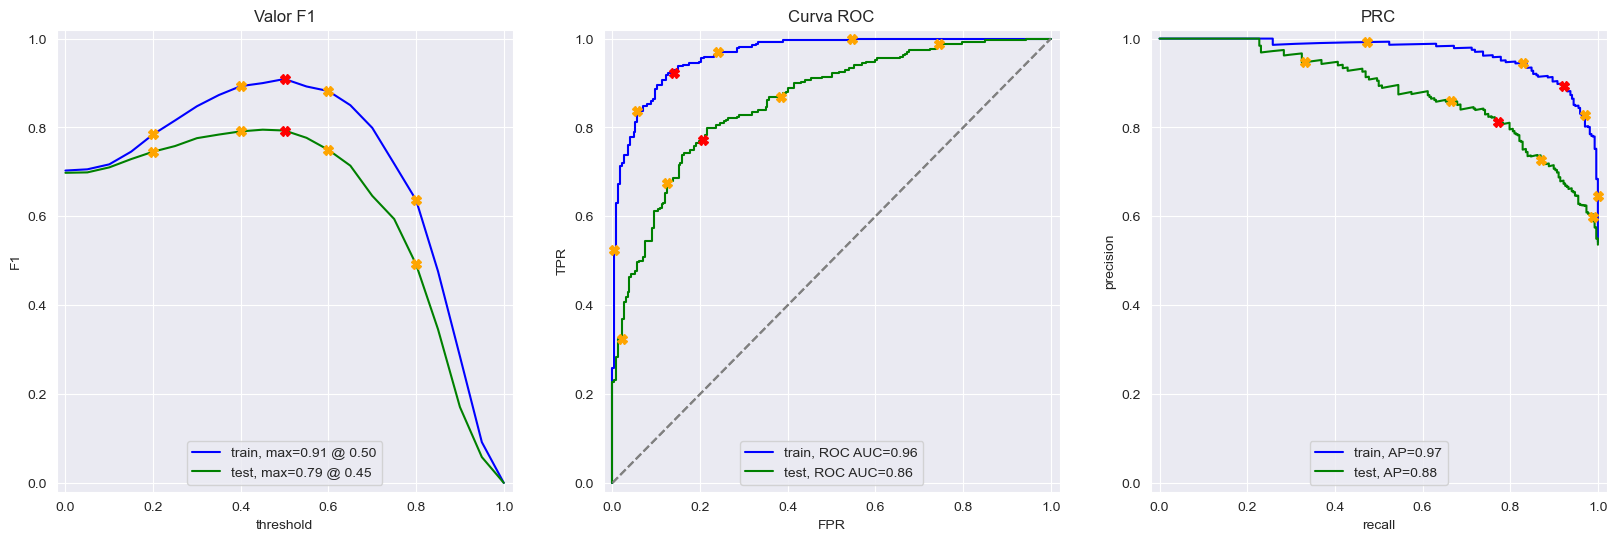

In [53]:
%%time
# Training LogisticRegression
params = {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
model_lr_3 = LogisticRegression(random_state= 12345, penalty=params['penalty'], C=params['C'], solver=params['solver'])
model_lr_3.fit(X_train_789, y_train_500)
result_7 = evaluate_model(model_lr_3, X_train_789, y_train_500, X_test_789, y_test_500)

In [54]:
summary_models.loc['model 7 - LogisticRegression'] = {'npl':'BERT', 'F1 train': result_7.iloc[1][0], 'F1 test': result_7.iloc[1][1]}

EL modelo entrenado con LogisticRegression ha obtenido un F1 tiene 0.91 en el entrenamiento, y 0.79 en la prueba. Existe un alto sobreajuste.

### 8-Entrenamiento con "RandomForestClassifier"

In [55]:
# Tuning hyperparameters:

# params_rf = {'n_estimators': [5, 100, 150],
#              'criterion': ["gini", "entropy", "log_loss"],
#              'max_depth': [4,6,8,10],
#              }

# params = grid_search_cv(RandomForestClassifier(random_state=12345), params_rf, X_train_789, y_train_500)

          train  test
Accuracy    1.0  0.75
F1          1.0  0.78
APS         1.0  0.85
ROC AUC     1.0  0.83
CPU times: total: 266 ms
Wall time: 1.54 s


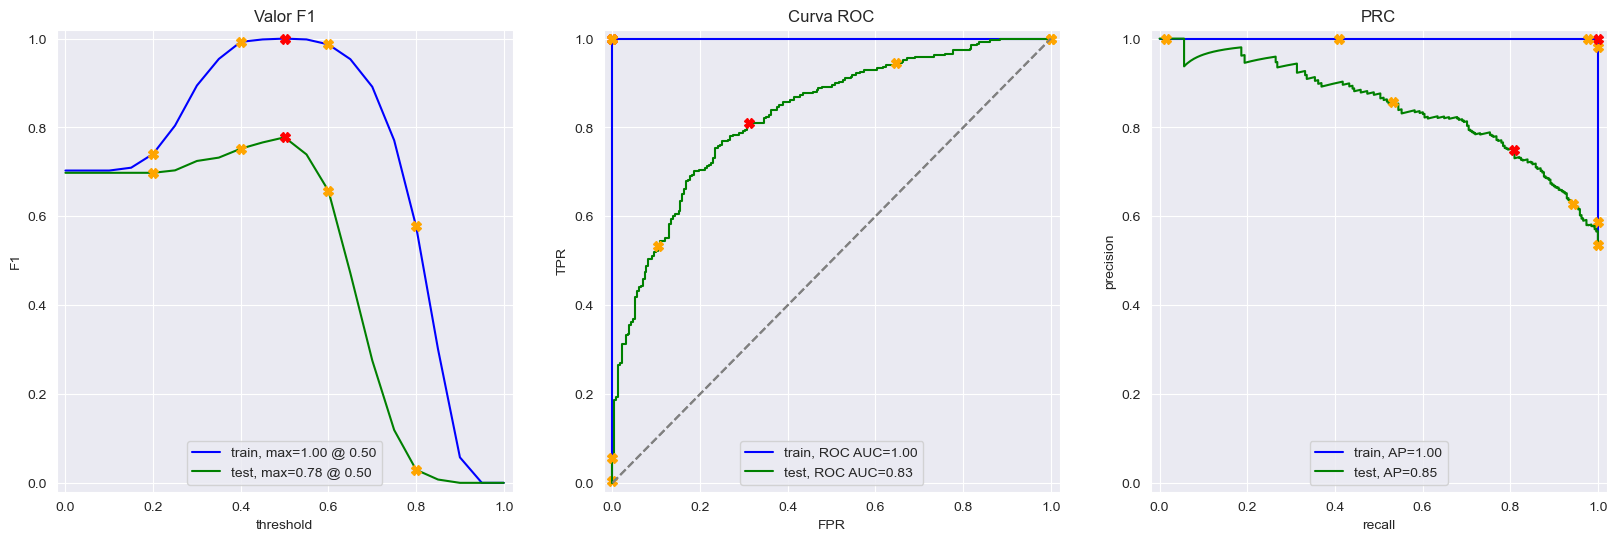

In [56]:
%%time
# Training RandomForestClassifier
params = {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 150}
model_rf_3 = RandomForestClassifier(n_estimators=params['n_estimators'], criterion=params['criterion'], max_depth=params['max_depth'] )
model_rf_3.fit(X_train_789, y_train_500)
result_8 = evaluate_model(model_rf_3, X_train_789, y_train_500, X_test_789, y_test_500 )

In [57]:
summary_models.loc['model 8 - RandomForestClassifier'] = {'npl':'BERT', 'F1 train': result_8.iloc[1][0], 'F1 test': result_8.iloc[1][1]}

EL modelo entrenado con RandomForestClassifier ha obtenido un F1 tiene 1 en el entrenamiento, y 0.78 en la prueba. Existe un altístimo sobreajuste.

### 9-Entrenamiento con "LGBMClassifier" 

In [58]:
# Tuning hyperparameters:

# params_lgbm = {
#     'objective' : ['binary'], 
#     'n_estimators' : [50, 100, 150],
#     'max_depth': [2,4,8]
# }

# params = grid_search_cv(LGBMClassifier(random_state=12345), params_lgbm, X_train_789, y_train_500)

          train  test
Accuracy    1.0  0.72
F1          1.0  0.73
APS         1.0  0.82
ROC AUC     1.0  0.80
CPU times: total: 15.5 s
Wall time: 1.45 s


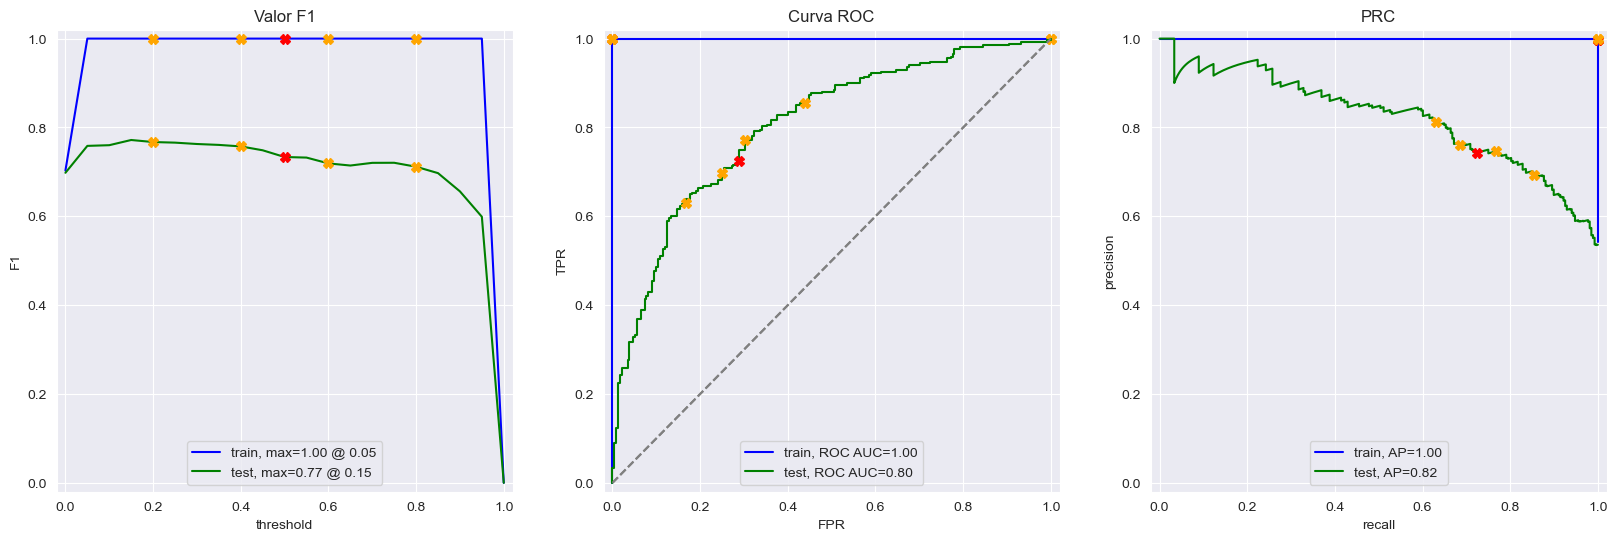

In [59]:
%%time
# Training LGBMClassifier
params = {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}
model_lgbm_3 = LGBMClassifier(random_state= 12345, n_estimators=params['n_estimators'], objective=params['objective'])
model_lgbm_3.fit(X_train_789, y_train_500)
result_9 = evaluate_model(model_lgbm_3, X_train_789, y_train_500, X_test_789, y_test_500 )

In [60]:
summary_models.loc['model 9 - LGBMClassifier'] = {'npl':'BERT', 'F1 train': result_9.iloc[1][0], 'F1 test': result_9.iloc[1][1]}

EL modelo entrenado con LGBMClassifier ha obtenido un F1 tiene 1 en el entrenamiento, y 0.73 en la prueba. Existe un altístimo sobreajuste al igual que los 2 anteriores.

El modelo 7, 8 y 9 fue entrenado con solo 500 reviews, por lo que su calidad bajó respecto a los primeros 6.

In [61]:
summary_models

,npl,F1 train,F1 test
model,,,
model 0 - dummy,only normalizer,0.67,0.66
model 1 - LogisticRegression,nltk and tfidf,0.93,0.88
model 2 - RandomForestClassifier,nltk and tfidf,0.93,0.88
model 3 - LGBMClassifier,nltk and tfidf,0.93,0.85
model 4 - LogisticRegression,spaCy and tfidf,0.93,0.88
model 5 - RandomForestClassifier,spaCy and tfidf,0.88,0.83
model 6 - LGBMClassifier,spaCy and tfidf,0.94,0.86
model 7 - LogisticRegression,BERT,0.91,0.79
model 8 - RandomForestClassifier,BERT,1.00,0.78


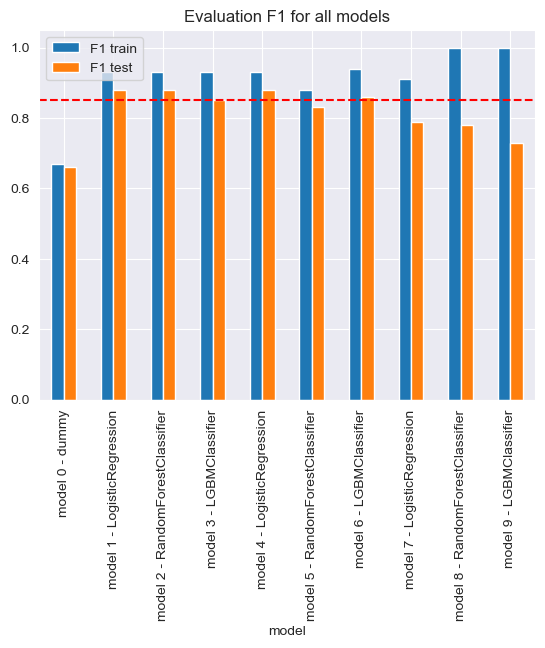

In [62]:
summary_models.plot(kind='bar', title='Evaluation F1 for all models')
plt.axhline(y=0.85, color='red', ls='--')
plt.show()

Los modelos que presentan mejores score son el modelo 1, 3, 4, 6, estos cumplen con un score superior a 0.85, pero en todos los casos presentan sobreajuste. El mejor score es el 1 y el 4.

Además claramente pasamos nuestra prueba de cordura, todos los entrenamientos superan el modelo dummy.

## Mis reseñas

In [63]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# normalizer
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews['feeling'] = [0, 0, 1, 0, 1, 1, 0, 1]

# features, target
features = my_reviews['review_norm']
target = my_reviews['feeling']

my_reviews

,review,review_norm,feeling
0,"I did not simply like it, not my kind of movie.",simply like kind movie,0
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie,0
2,I was really fascinated with the movie,really fascinated movie,1
3,Even the actors looked really old and disinter...,even actors looked really old disinterested go...,0
4,I didn't expect the reboot to be so good! Writ...,expect reboot good writers really cared source...,1
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall dece...,1
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke lands everyo...,0
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...,1


Calculamos predicciones con nuestros mejores modelos.

los modelos entrandos están en las siguientes variables:
- modelo 1 - `model_lr`
- modelo 3 - `model_lgbm`
- modelo 4 - `model_lr_2`
- modelo 6 - `model_lgbm_2`

In [64]:
# NPL 
npl_123 = vectorizer_123.transform(features)
npl_456 = vectorizer_456.transform(features)

# calculate predictions with best models:
my_reviews['pred_m1'] = model_lr.predict(npl_123)
my_reviews['pred_m3']  = model_lgbm.predict(npl_123)
my_reviews['pred_m4'] = model_lr_2.predict(npl_456)
my_reviews['pred_m6']  = model_lgbm_2.predict(npl_456)

print('Predictions:')
display(my_reviews.drop('review_norm', axis=1))

Predictions:


,review,feeling,pred_m1,pred_m3,pred_m4,pred_m6
0,"I did not simply like it, not my kind of movie.",0,0,1,0,1
1,"Well, I was bored and felt asleep in the middl...",0,0,1,0,0
2,I was really fascinated with the movie,1,0,1,1,1
3,Even the actors looked really old and disinter...,0,0,1,0,0
4,I didn't expect the reboot to be so good! Writ...,1,0,1,0,1
5,"The movie had its upsides and downsides, but I...",1,1,1,0,1
6,What a rotten attempt at a comedy. Not a singl...,0,0,1,0,0
7,Launching on Netflix was a brave move & I real...,1,1,1,1,1


Hemos realizado predicciones con nuestros mejores modelos:
- modelo 1 - 6/8, 75% aciertos
- modelo 3 - 4/4, 50% aciertos
- modelo 4 - 6/8, 75% aciertos
- modelo 6 - 7/8, 88% aciertos

# Conclusiones

Utilizamos un conjunto de datos de reseñas de películas de IMDB con etiquetados y entrenamos varios modelos para clasificar las reseñas como positivas y negativas. 

Utilizamos técnicas de procesamiento de texto, como normalización de texto donde limpiamos nuestros reviews de caracteres no deseados, dígitos y palabras vacías. Además de aplicar técnicas de lematización usando NTLK y spaCy, además de TF-IDF para transformar nuestros textos en números.

Realizamos el entrenamiento de 9 modelos + un modelo constante con el cual pudimos evidenciar que la prueba de cordura fue exitosa.

De los modelos a continuación el 1, 3, 4 y 6 obtuvieron mejores score en las pruebas:

- **model 1 - LogisticRegression, nltk and tfidf, F1 0.88**
- model 2 - RandomForestClassifier, nltk and tfidf, f1 0.84
- **model 3 - LGBMClassifier, nltk and tfidf, f1 0.85**
- **model 4 - LogisticRegression, spaCy and tfidf, f1 0.88**
- model 5 - RandomForestClassifier, spaCy and tfidf 0.83
- **model 6 - LGBMClassifier, spaCy and tfidf, f1 0.86**
- model 7 - LogisticRegression, BERT, f1 0.79
- model 8 - RandomForestClassifier, BERT, f1 0.77
- model 9 - LGBMClassifier, BERT, f1 0.73

Logrando nuestro objetivo superar un valor F1 de al menos 0.85.

Finalmente realizamos predicciones de 8 nuevas reviews de películas de lo cual obtuvimos que el modelo 6 con un procesamiento de texto spaCy y TF-IDF y entrenado con el algoritmo LGBMClassifier, obtuvo excelentes predicciones, acertando en un 88%.